# LSTMABAR Model Evaluation on Test Set

Comprehensive evaluation of the best quantum model on held-out test data with publication-quality visualizations.

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import json
from datetime import datetime
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import confusion_matrix, classification_report, r2_score
import librosa

# Import model
from lstmabar_model import LSTMABAR

# Set style for publication-quality plots
try:
    plt.style.use('seaborn-v0_8-paper')
except:
    try:
        plt.style.use('seaborn-paper')
    except:
        pass
sns.set_palette('husl')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 9

print("✓ Imports complete")

/home/zain/anaconda3/envs/lab3py313/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


=== Testing Archetype Prediction ===
Predicted weights shape: torch.Size([8, 5])
Sample prediction: tensor([0.0663, 0.0704, 0.3011, 0.3364, 0.2257], grad_fn=<SelectBackward0>)
Sum of weights: 1.000000 (should be ~1.0)

Named predictions for sample 0:
  sine: 0.1246
  square: 0.2364
  sawtooth: 0.2289
  triangle: 0.2931
  noise: 0.1170

=== Testing Archetype Loss ===
MSE loss: 0.0389

=== Testing RLHF Trainer with Audio Playback ===

HUMAN FEEDBACK COLLECTION

Description: 'bright and cutting guitar tone'

Predicted Archetype Weights:
  sine      : █ 0.066
  square    : █ 0.070
  sawtooth  : ██████ 0.301
  triangle  : ██████ 0.336
  noise     : ████ 0.226

------------------------------------------------------------
AUDIO PLAYBACK
------------------------------------------------------------

▶️  ORIGINAL AUDIO:



▶️  TRANSFORMED AUDIO:



------------------------------------------------------------
RATING INSTRUCTIONS
------------------------------------------------------------
Rate how well the transformation matches the description:
  5 = Perfect match
  4 = Good match
  3 = Acceptable match
  2 = Poor match
  1 = Very poor match

✓ Feedback recorded: 5.0/5


=== Interactive RLHF Usage Example ===

# In Jupyter notebook, use this pattern:

# 1. Generate or load audio samples
original_audio = librosa.load('input.wav')[0]
transformed_audio = model.transform(original_audio, description)

# 2. Get embeddings and predictions
text_emb = text_encoder([description])
audio_emb = audio_encoder(torch.from_numpy(original_audio))
predicted_weights = predictor(text_emb, audio_emb)

# 3. Collect interactive feedback with audio playback
rating = rlhf_trainer.collect_feedback_with_audio(
description="bright and crunchy",
original_audio=original_audio,
transformed_audio=transformed_audio,
predicted_weights=predicted_weights[0].cpu().n

## 1. Load Model and Test Data

In [2]:
# Configuration
MODEL_PATH = 'tuning_checkpoints/mids266final_bestmodel/best_model.pth'
TEST_DATA_PATH = 'musiccaps_training_data_test.npz'
OUTPUT_DIR = Path('evaluation_results')
OUTPUT_DIR.mkdir(exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load model
print("\nLoading model...")
checkpoint = torch.load(MODEL_PATH, map_location=device)

model = LSTMABAR(
    sample_rate=44100,
    use_quantum_attention=True,
    device=device
)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✓ Loaded model from epoch {checkpoint.get('epoch', 'unknown')}")
if 'train_loss' in checkpoint:
    print(f"  Final train loss: {checkpoint['train_loss']:.4f}")

print("\n" + "="*60)

Using device: cpu

Loading model...
Loading text encoder: sentence-transformers/all-MiniLM-L6-v2
✓ Loaded model from epoch 4



In [3]:
# Load test data
print("LOADING TEST DATA")
print("="*60)

print(f"\nLoading from: {TEST_DATA_PATH}")
test_data = np.load(TEST_DATA_PATH, allow_pickle=True)

print(f"Available keys: {list(test_data.keys())}")

# Extract metadata
test_descriptions = test_data['descriptions']
test_archetypes = test_data['archetype_vectors']
test_audio_paths = test_data['audio_paths']
archetype_names = list(test_data['archetype_order'])

print(f"\n✓ Metadata loaded: {len(test_descriptions)} test samples")
print(f"  Archetype order: {archetype_names}")

LOADING TEST DATA

Loading from: musiccaps_training_data_test.npz
Available keys: ['archetype_vectors', 'descriptions', 'audio_paths', 'archetype_order']

✓ Metadata loaded: 794 test samples
  Archetype order: [np.str_('sine'), np.str_('square'), np.str_('sawtooth'), np.str_('triangle'), np.str_('noise')]


In [4]:
# Load audio from paths
def load_audio_from_paths(audio_paths, sample_rate=44100, max_duration=10.0):
    """Load audio from file paths"""
    loaded_audio = []
    failed = []
    max_length = int(sample_rate * max_duration)
    
    for audio_path in tqdm(audio_paths, desc="Loading test audio"):
        audio_path = str(audio_path)
        try:
            audio, sr = librosa.load(audio_path, sr=sample_rate, duration=max_duration)
            # Pad or trim to consistent length
            if len(audio) < max_length:
                audio = np.pad(audio, (0, max_length - len(audio)))
            else:
                audio = audio[:max_length]
            loaded_audio.append(audio)
        except Exception as e:
            if len(failed) < 5:
                print(f"\n  Failed: {audio_path}: {e}")
            # Use zeros if file missing
            loaded_audio.append(np.zeros(max_length))
            failed.append(audio_path)
    
    if failed:
        print(f"\n  Warning: {len(failed)}/{len(audio_paths)} files failed to load")
    
    return np.array(loaded_audio), failed

print("\n🎵 Loading test audio files...")
test_audio, test_failed = load_audio_from_paths(
    test_audio_paths,
    sample_rate=44100,
    max_duration=10.0
)

print(f"\n✓ Test data loaded")
print(f"  Audio shape: {test_audio.shape}")
print(f"  Descriptions: {len(test_descriptions)}")
print(f"  Target archetypes: {test_archetypes.shape}")
print(f"  Failed files: {len(test_failed)}")


🎵 Loading test audio files...


Loading test audio: 100%|██████████| 794/794 [00:10<00:00, 77.58it/s]



✓ Test data loaded
  Audio shape: (794, 441000)
  Descriptions: 794
  Target archetypes: (794, 5)
  Failed files: 0


## 2. Run Inference on Test Set

In [5]:
print("\n" + "="*60)
print("RUNNING INFERENCE ON TEST SET")
print("="*60 + "\n")

predictions = []
text_embeddings_list = []
audio_embeddings_list = []

with torch.no_grad():
    for i in tqdm(range(len(test_audio)), desc="Evaluating"):
        audio = test_audio[i]
        description = test_descriptions[i]
        target = test_archetypes[i]
        
        # Convert to tensor
        audio_tensor = torch.from_numpy(audio).unsqueeze(0).float().to(device)
        
        # Use model's inference method (same as RLHF notebook)
        transformed, metadata = model.inference([description], audio_tensor)
        predicted = metadata['predicted_weights'][0]
        
        # Also get embeddings for analysis
        text_emb = model.encode_text([description])
        audio_emb, _ = model.encode_audio(audio_tensor)
        
        # Store results
        predictions.append({
            'index': i,
            'description': description,
            'predicted': predicted,
            'target': target,
            'text_embedding': text_emb.squeeze(0).cpu().numpy(),
            'audio_embedding': audio_emb.squeeze(0).cpu().numpy()
        })

print(f"\n✓ Completed inference on {len(predictions)} samples")


RUNNING INFERENCE ON TEST SET



Evaluating: 100%|██████████| 794/794 [10:01<00:00,  1.32it/s]


✓ Completed inference on 794 samples


## 3. Compute Metrics

In [6]:
# Extract arrays
predicted_array = np.array([p['predicted'] for p in predictions])
target_array = np.array([p['target'] for p in predictions])

# Compute metrics
def compute_metrics(predicted, target):
    """Compute comprehensive evaluation metrics"""
    metrics = {}
    
    # MSE (Mean Squared Error)
    mse = np.mean((predicted - target) ** 2)
    metrics['mse'] = float(mse)
    metrics['rmse'] = float(np.sqrt(mse))
    
    # MAE (Mean Absolute Error)
    mae = np.mean(np.abs(predicted - target))
    metrics['mae'] = float(mae)
    
    # Cosine Similarity (per sample, then averaged)
    cos_sims = []
    for p, t in zip(predicted, target):
        cos_sim = np.dot(p, t) / (np.linalg.norm(p) * np.linalg.norm(t) + 1e-8)
        cos_sims.append(cos_sim)
    metrics['cosine_similarity'] = float(np.mean(cos_sims))
    metrics['cosine_similarity_std'] = float(np.std(cos_sims))
    
    # Top-1 Accuracy (dominant archetype matches)
    pred_top1 = np.argmax(predicted, axis=1)
    target_top1 = np.argmax(target, axis=1)
    top1_acc = np.mean(pred_top1 == target_top1)
    metrics['top1_accuracy'] = float(top1_acc)
    
    # Top-2 Accuracy
    pred_top2 = np.argsort(predicted, axis=1)[:, -2:]
    top2_acc = np.mean([target_top1[i] in pred_top2[i] for i in range(len(target_top1))])
    metrics['top2_accuracy'] = float(top2_acc)
    
    # Per-archetype MSE
    for i, name in enumerate(archetype_names):
        arch_mse = np.mean((predicted[:, i] - target[:, i]) ** 2)
        metrics[f'{name}_mse'] = float(arch_mse)
    
    # Correlation coefficients
    pearson_corrs = []
    spearman_corrs = []
    for i in range(predicted.shape[1]):
        pearson_r, _ = pearsonr(predicted[:, i], target[:, i])
        spearman_r, _ = spearmanr(predicted[:, i], target[:, i])
        pearson_corrs.append(pearson_r)
        spearman_corrs.append(spearman_r)
    
    metrics['pearson_correlation'] = float(np.mean(pearson_corrs))
    metrics['spearman_correlation'] = float(np.mean(spearman_corrs))
    
    return metrics

# Compute all metrics
metrics = compute_metrics(predicted_array, target_array)

# Display metrics
print("="*60)
print("TEST SET METRICS")
print("="*60)
print(f"\nOverall Performance:")
print(f"  MSE:                 {metrics['mse']:.4f}")
print(f"  RMSE:                {metrics['rmse']:.4f}")
print(f"  MAE:                 {metrics['mae']:.4f}")
print(f"  Cosine Similarity:   {metrics['cosine_similarity']:.4f} ± {metrics['cosine_similarity_std']:.4f}")
print(f"  Pearson Correlation: {metrics['pearson_correlation']:.4f}")
print(f"  Spearman Correlation:{metrics['spearman_correlation']:.4f}")

print(f"\nArchetype Classification:")
print(f"  Top-1 Accuracy:      {metrics['top1_accuracy']*100:.2f}%")
print(f"  Top-2 Accuracy:      {metrics['top2_accuracy']*100:.2f}%")

print(f"\nPer-Archetype MSE:")
for name in archetype_names:
    print(f"  {name:10s}: {metrics[f'{name}_mse']:.4f}")

# Save metrics
metrics['timestamp'] = datetime.now().isoformat()
metrics['model_path'] = MODEL_PATH
metrics['test_samples'] = len(predictions)

with open(OUTPUT_DIR / 'test_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"\n✓ Metrics saved to {OUTPUT_DIR / 'test_metrics.json'}")

TEST SET METRICS

Overall Performance:
  MSE:                 0.0639
  RMSE:                0.2527
  MAE:                 0.1801
  Cosine Similarity:   0.7474 ± 0.2220
  Pearson Correlation: 0.5225
  Spearman Correlation:0.4541

Archetype Classification:
  Top-1 Accuracy:      56.68%
  Top-2 Accuracy:      77.71%

Per-Archetype MSE:
  sine      : 0.1131
  square    : 0.0523
  sawtooth  : 0.0572
  triangle  : 0.0545
  noise     : 0.0421

✓ Metrics saved to evaluation_results/test_metrics.json


## 4. Visualization 1: Prediction vs Target Scatter

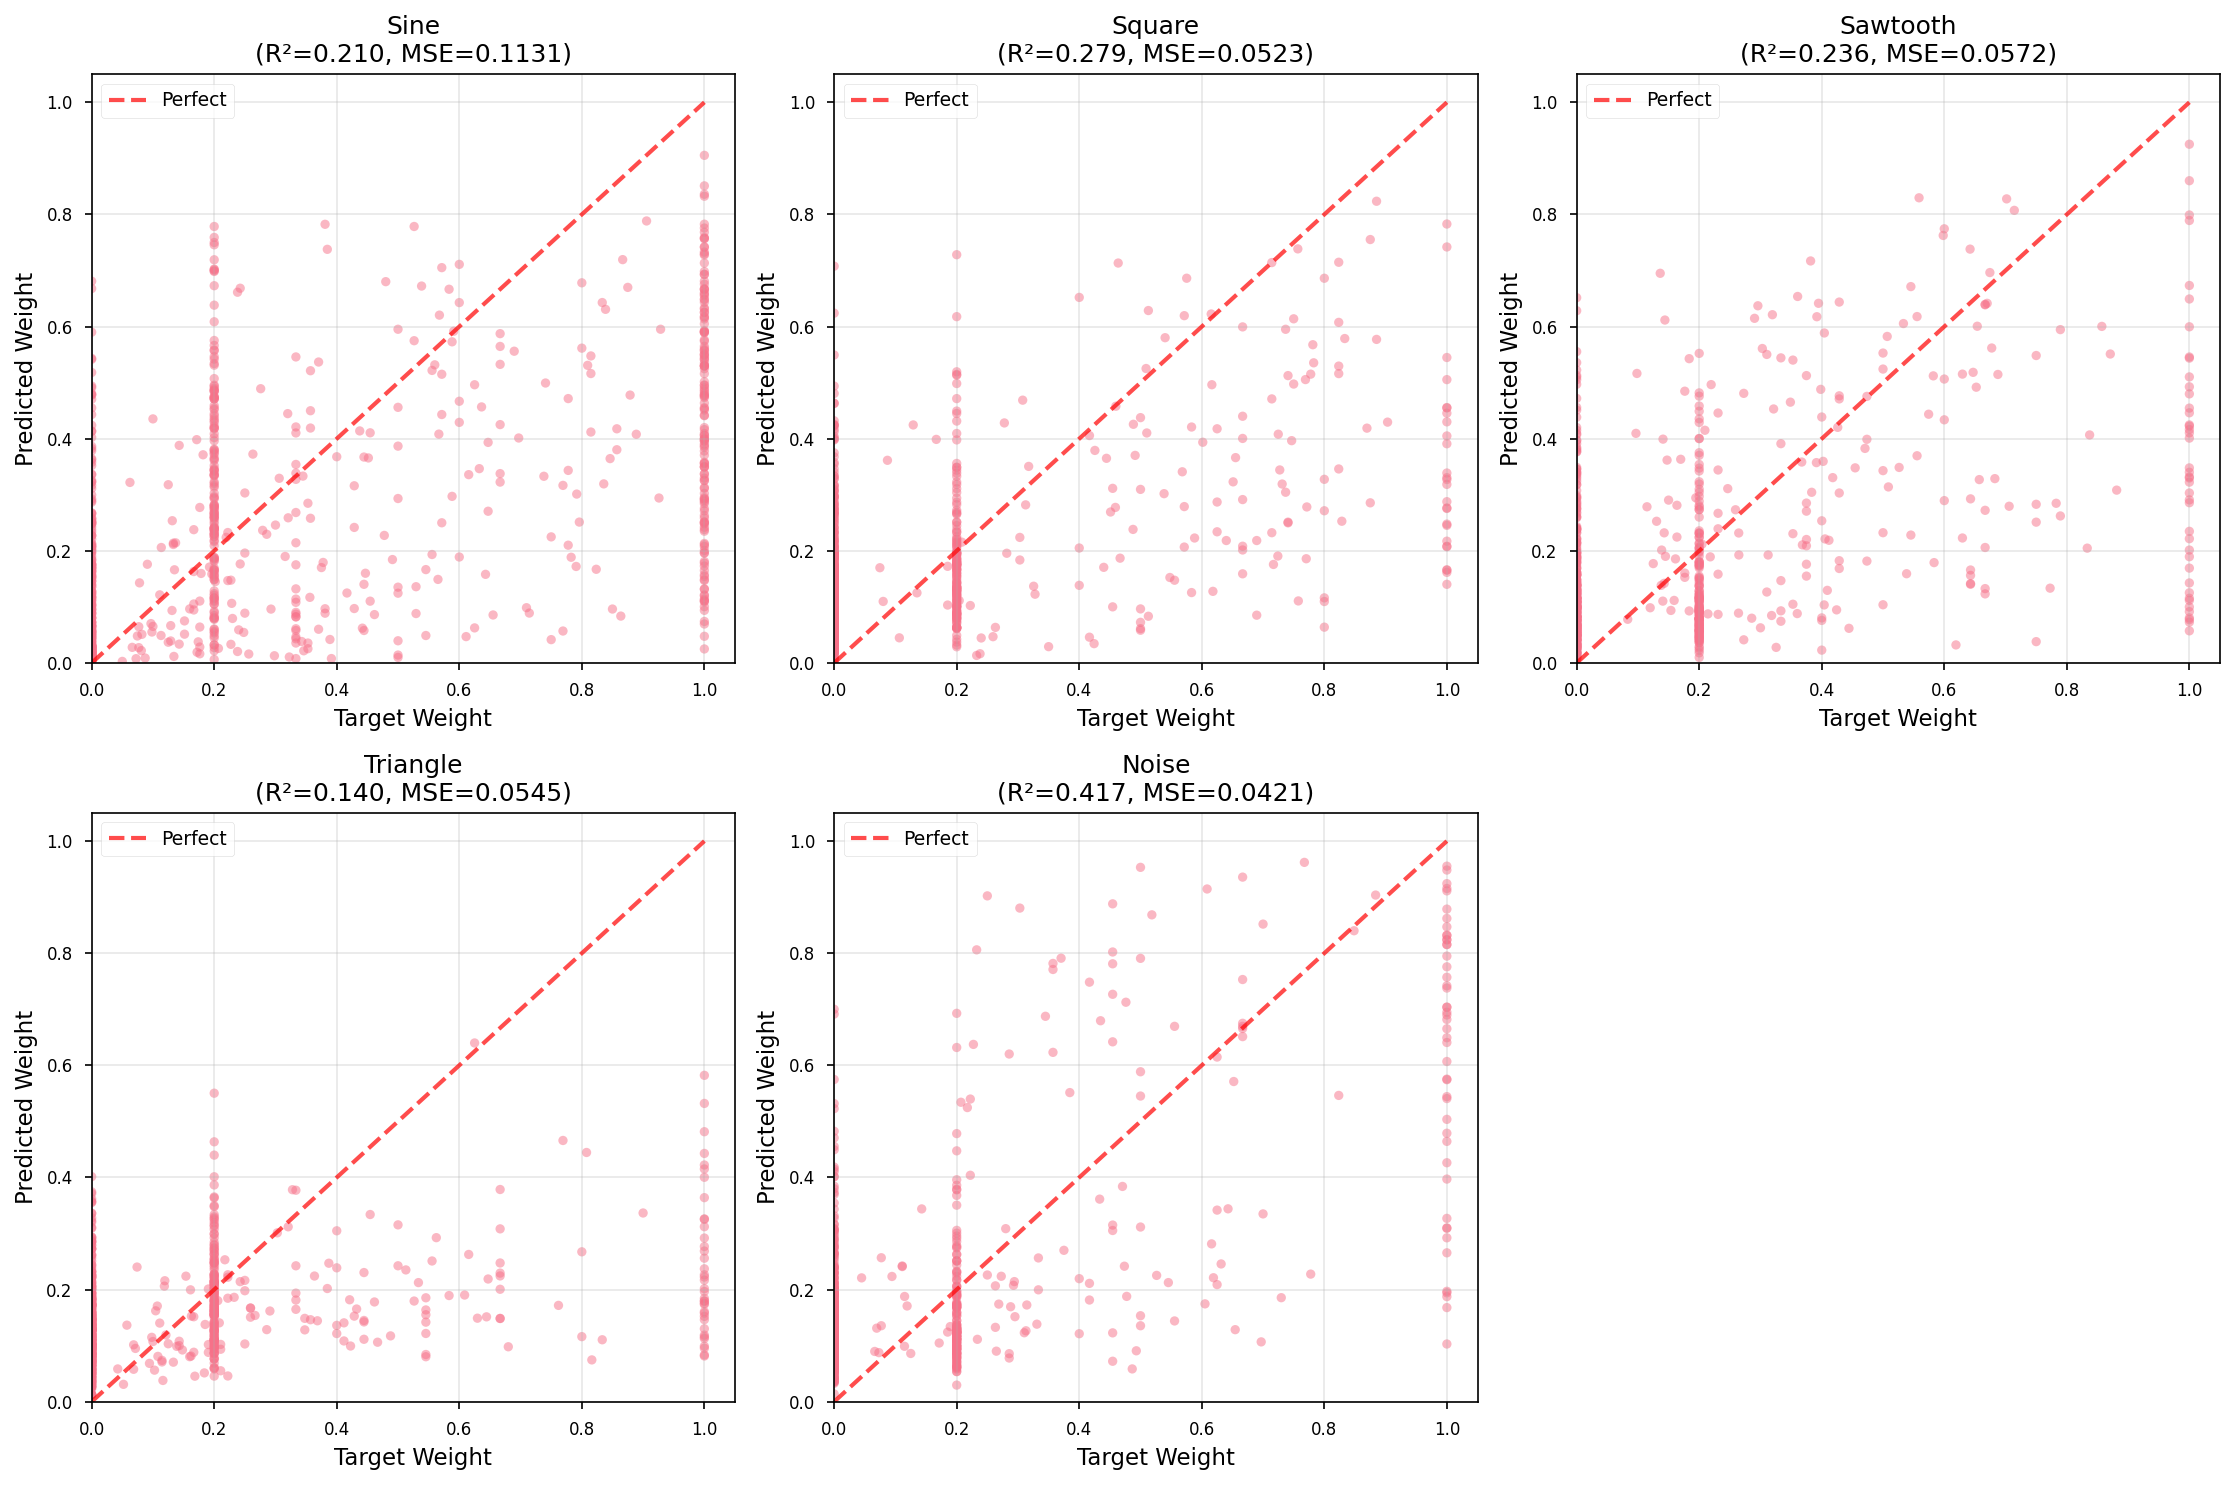

✓ Saved prediction vs target scatter plots


In [7]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, name in enumerate(archetype_names):
    ax = axes[i]
    
    # Scatter plot
    ax.scatter(target_array[:, i], predicted_array[:, i], 
               alpha=0.5, s=20, edgecolors='none')
    
    # Perfect prediction line
    max_val = max(target_array[:, i].max(), predicted_array[:, i].max())
    ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, alpha=0.7, label='Perfect')
    
    # Compute R²
    r2 = r2_score(target_array[:, i], predicted_array[:, i])
    
    ax.set_xlabel('Target Weight')
    ax.set_ylabel('Predicted Weight')
    ax.set_title(f'{name.capitalize()}\n(R²={r2:.3f}, MSE={metrics[f"{name}_mse"]:.4f})')
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.set_xlim(0, max_val * 1.05)
    ax.set_ylim(0, max_val * 1.05)

# Remove extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'prediction_vs_target_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved prediction vs target scatter plots")

## 5. Visualization 2: Confusion Matrix (Top-1 Archetype)

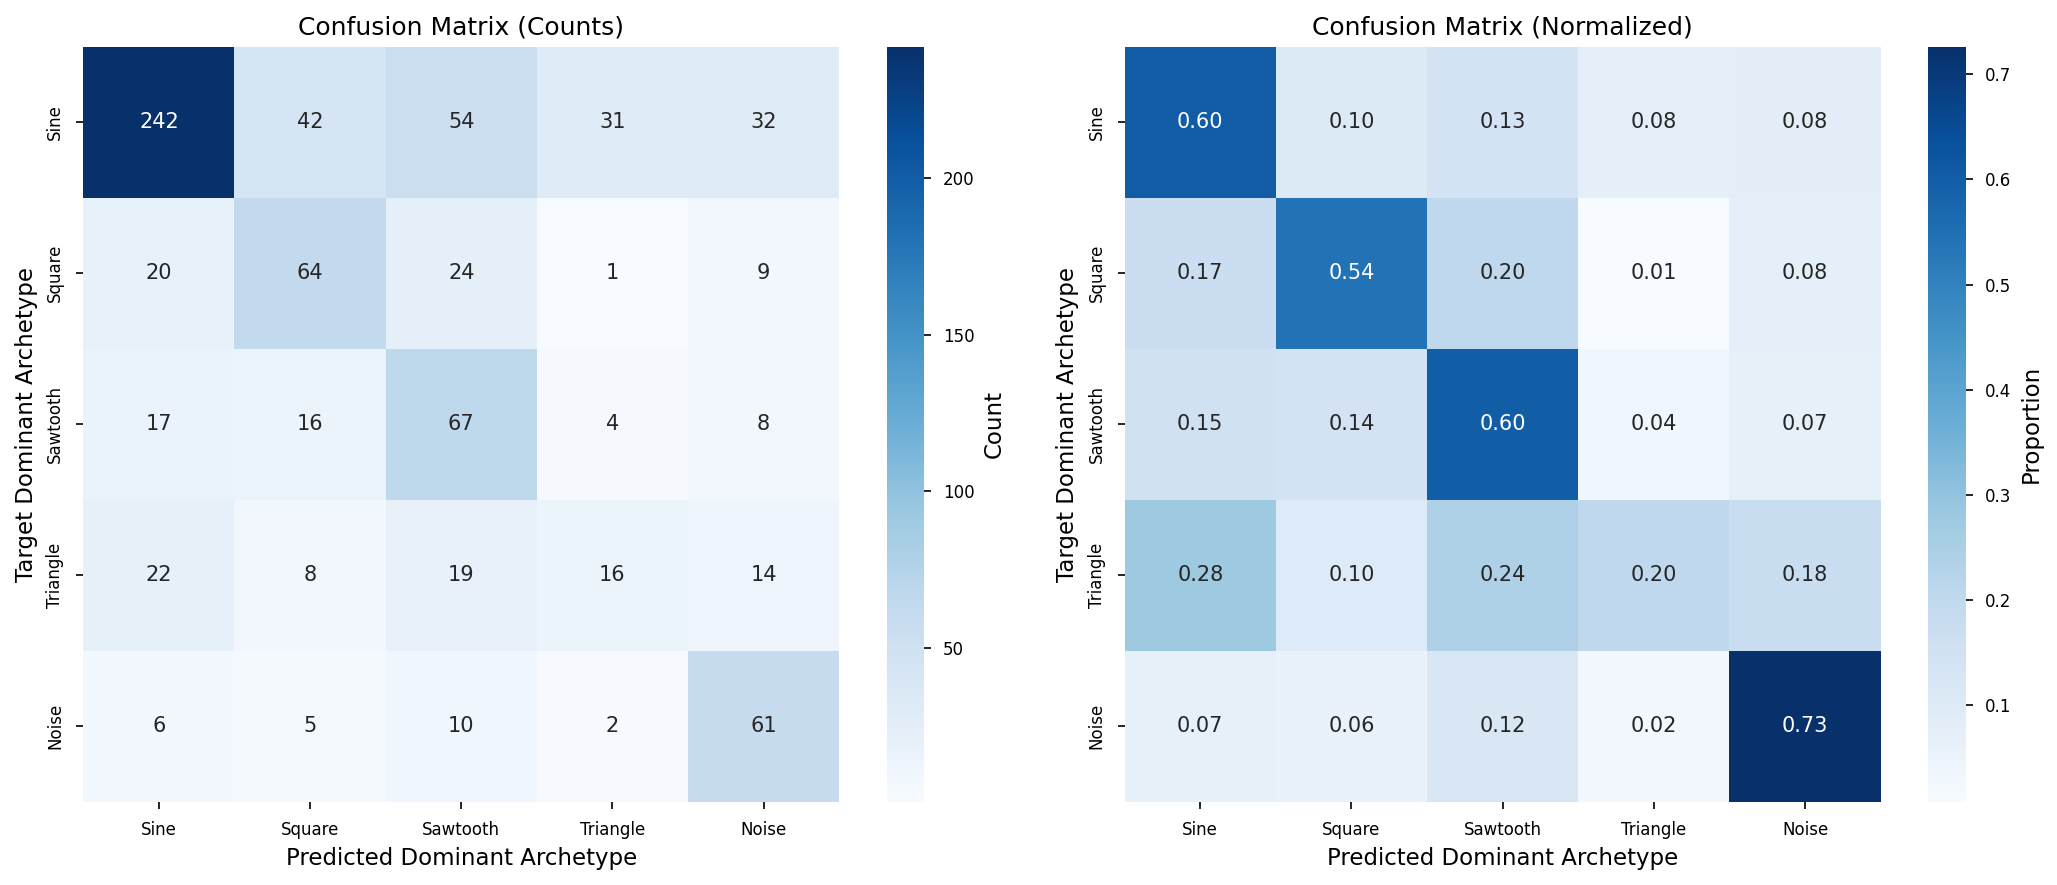


Classification Report (Dominant Archetype):
              precision    recall  f1-score   support

        Sine       0.79      0.60      0.68       401
      Square       0.47      0.54      0.51       118
    Sawtooth       0.39      0.60      0.47       112
    Triangle       0.30      0.20      0.24        79
       Noise       0.49      0.73      0.59        84

    accuracy                           0.57       794
   macro avg       0.49      0.53      0.50       794
weighted avg       0.60      0.57      0.57       794

✓ Saved confusion matrix and classification report


In [8]:
# Get top-1 predictions
pred_top1 = np.argmax(predicted_array, axis=1)
target_top1 = np.argmax(target_array, axis=1)

# Confusion matrix
cm = confusion_matrix(target_top1, pred_top1)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Absolute counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[n.capitalize() for n in archetype_names],
            yticklabels=[n.capitalize() for n in archetype_names],
            ax=ax1, cbar_kws={'label': 'Count'})
ax1.set_xlabel('Predicted Dominant Archetype')
ax1.set_ylabel('Target Dominant Archetype')
ax1.set_title('Confusion Matrix (Counts)')

# Normalized percentages
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=[n.capitalize() for n in archetype_names],
            yticklabels=[n.capitalize() for n in archetype_names],
            ax=ax2, cbar_kws={'label': 'Proportion'})
ax2.set_xlabel('Predicted Dominant Archetype')
ax2.set_ylabel('Target Dominant Archetype')
ax2.set_title('Confusion Matrix (Normalized)')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification report
report = classification_report(target_top1, pred_top1, 
                                target_names=[n.capitalize() for n in archetype_names],
                                output_dict=True)

print("\nClassification Report (Dominant Archetype):")
print(classification_report(target_top1, pred_top1, 
                            target_names=[n.capitalize() for n in archetype_names]))

# Save report
with open(OUTPUT_DIR / 'classification_report.json', 'w') as f:
    json.dump(report, f, indent=2)

print("✓ Saved confusion matrix and classification report")

## 6. Visualization 3: Error Distribution

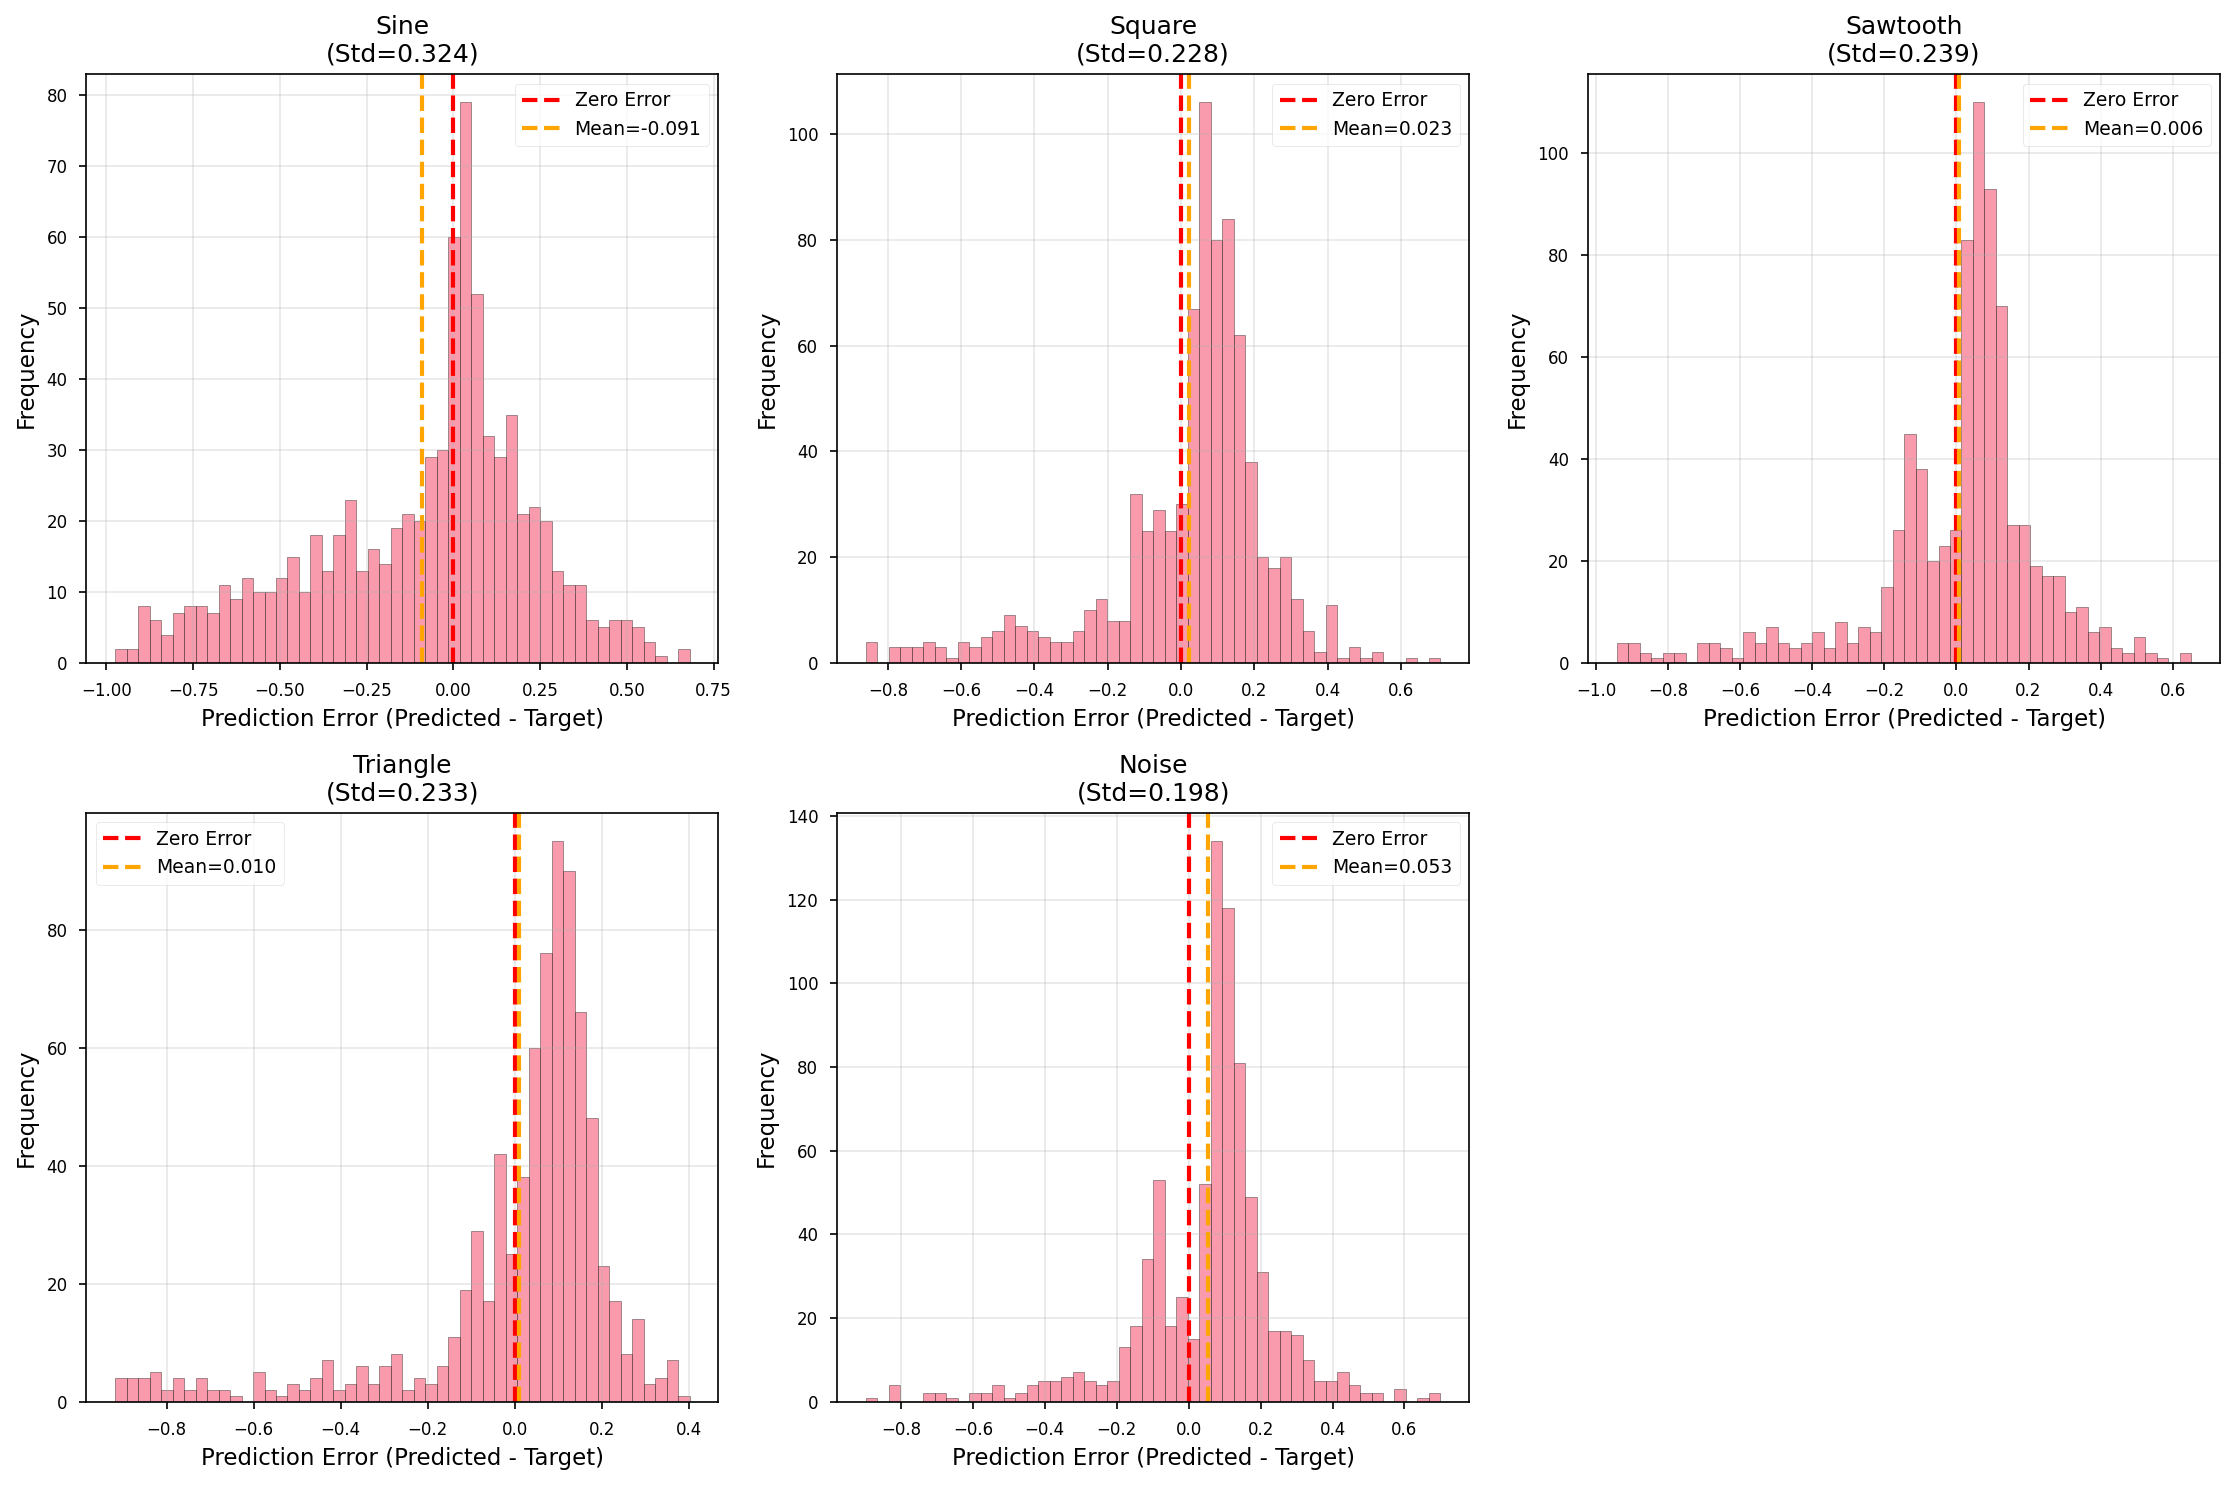

✓ Saved error distribution plots


In [9]:
# Compute errors per archetype
errors = predicted_array - target_array

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, name in enumerate(archetype_names):
    ax = axes[i]
    
    # Histogram of errors
    ax.hist(errors[:, i], bins=50, alpha=0.7, edgecolor='black')
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    ax.axvline(errors[:, i].mean(), color='orange', linestyle='--', 
               linewidth=2, label=f'Mean={errors[:, i].mean():.3f}')
    
    ax.set_xlabel('Prediction Error (Predicted - Target)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{name.capitalize()}\n(Std={errors[:, i].std():.3f})')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved error distribution plots")

## 7. Visualization 4: Archetype Weight Distributions

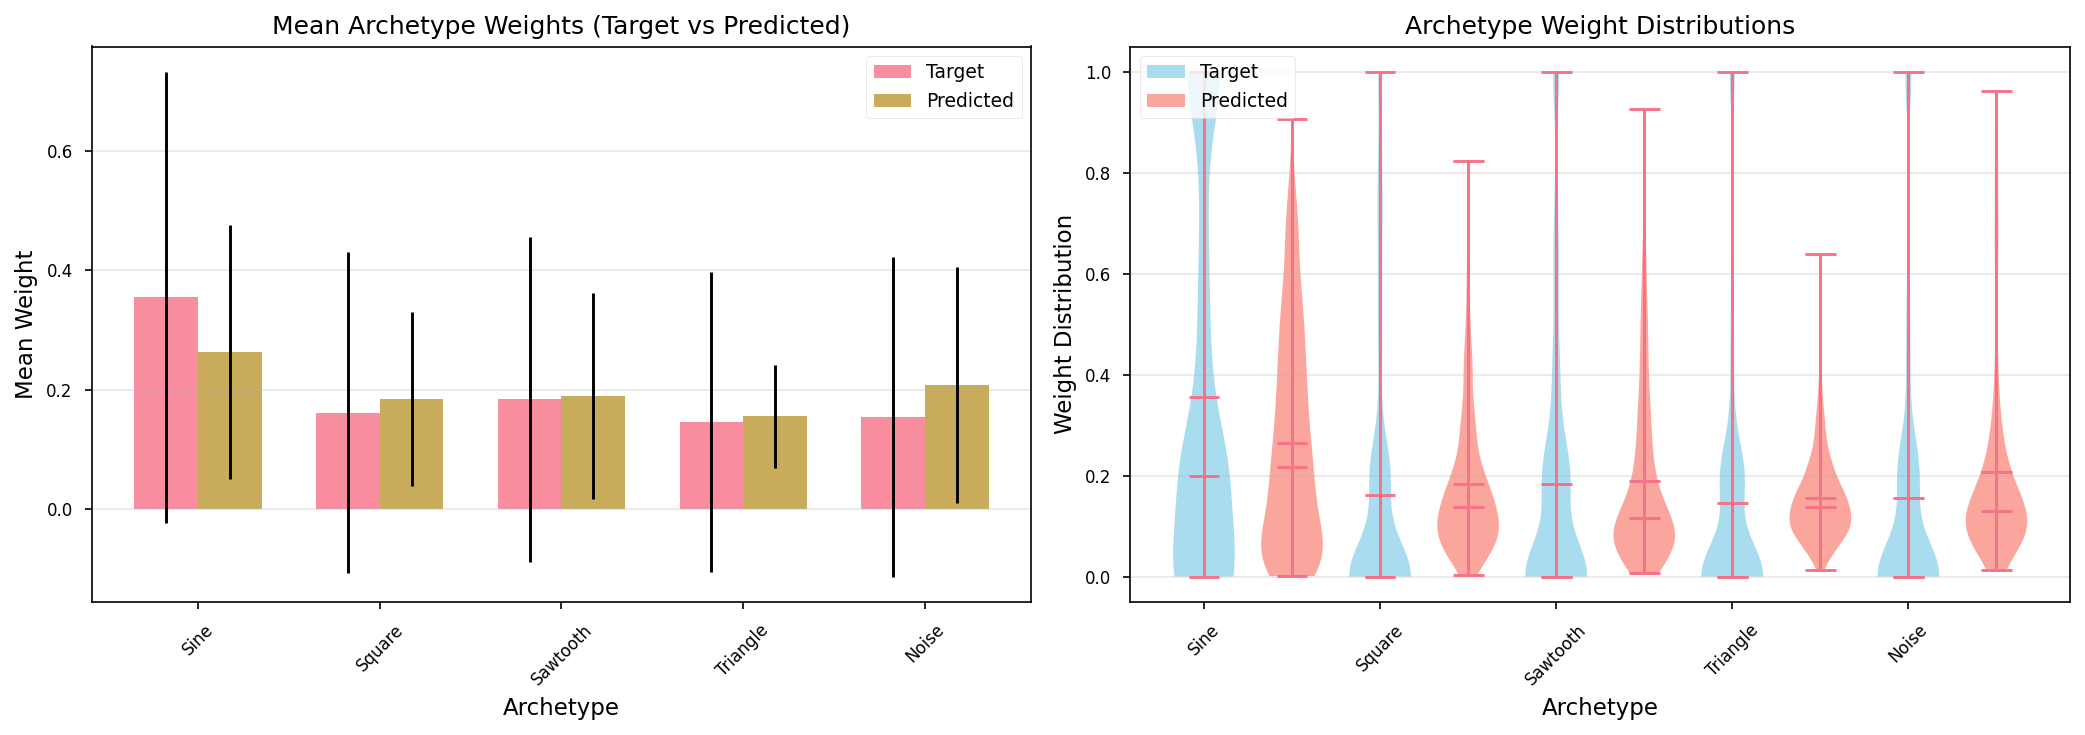

✓ Saved archetype distribution plots


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Target vs Predicted means
ax1 = axes[0]
positions = np.arange(len(archetype_names))
width = 0.35

target_means = target_array.mean(axis=0)
target_stds = target_array.std(axis=0)
predicted_means = predicted_array.mean(axis=0)
predicted_stds = predicted_array.std(axis=0)

ax1.bar(positions - width/2, target_means, width, 
        yerr=target_stds, label='Target', alpha=0.8, capsize=5)
ax1.bar(positions + width/2, predicted_means, width,
        yerr=predicted_stds, label='Predicted', alpha=0.8, capsize=5)

ax1.set_xlabel('Archetype')
ax1.set_ylabel('Mean Weight')
ax1.set_title('Mean Archetype Weights (Target vs Predicted)')
ax1.set_xticks(positions)
ax1.set_xticklabels([n.capitalize() for n in archetype_names], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Violin plots
ax2 = axes[1]
data_to_plot = []
labels = []

for i, name in enumerate(archetype_names):
    data_to_plot.append(target_array[:, i])
    data_to_plot.append(predicted_array[:, i])
    labels.append(f'{name.capitalize()}\n(Target)')
    labels.append(f'{name.capitalize()}\n(Pred)')

parts = ax2.violinplot(data_to_plot, positions=range(len(data_to_plot)), 
                        widths=0.7, showmeans=True, showmedians=True)

# Color target vs predicted differently
for i, pc in enumerate(parts['bodies']):
    if i % 2 == 0:  # Target
        pc.set_facecolor('skyblue')
        pc.set_alpha(0.7)
    else:  # Predicted
        pc.set_facecolor('salmon')
        pc.set_alpha(0.7)

ax2.set_xlabel('Archetype')
ax2.set_ylabel('Weight Distribution')
ax2.set_title('Archetype Weight Distributions')
ax2.set_xticks(range(0, len(labels), 2))
ax2.set_xticklabels([n.capitalize() for n in archetype_names], rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='skyblue', alpha=0.7, label='Target'),
                   Patch(facecolor='salmon', alpha=0.7, label='Predicted')]
ax2.legend(handles=legend_elements)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'archetype_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved archetype distribution plots")

## 8. Visualization 5: Best and Worst Predictions

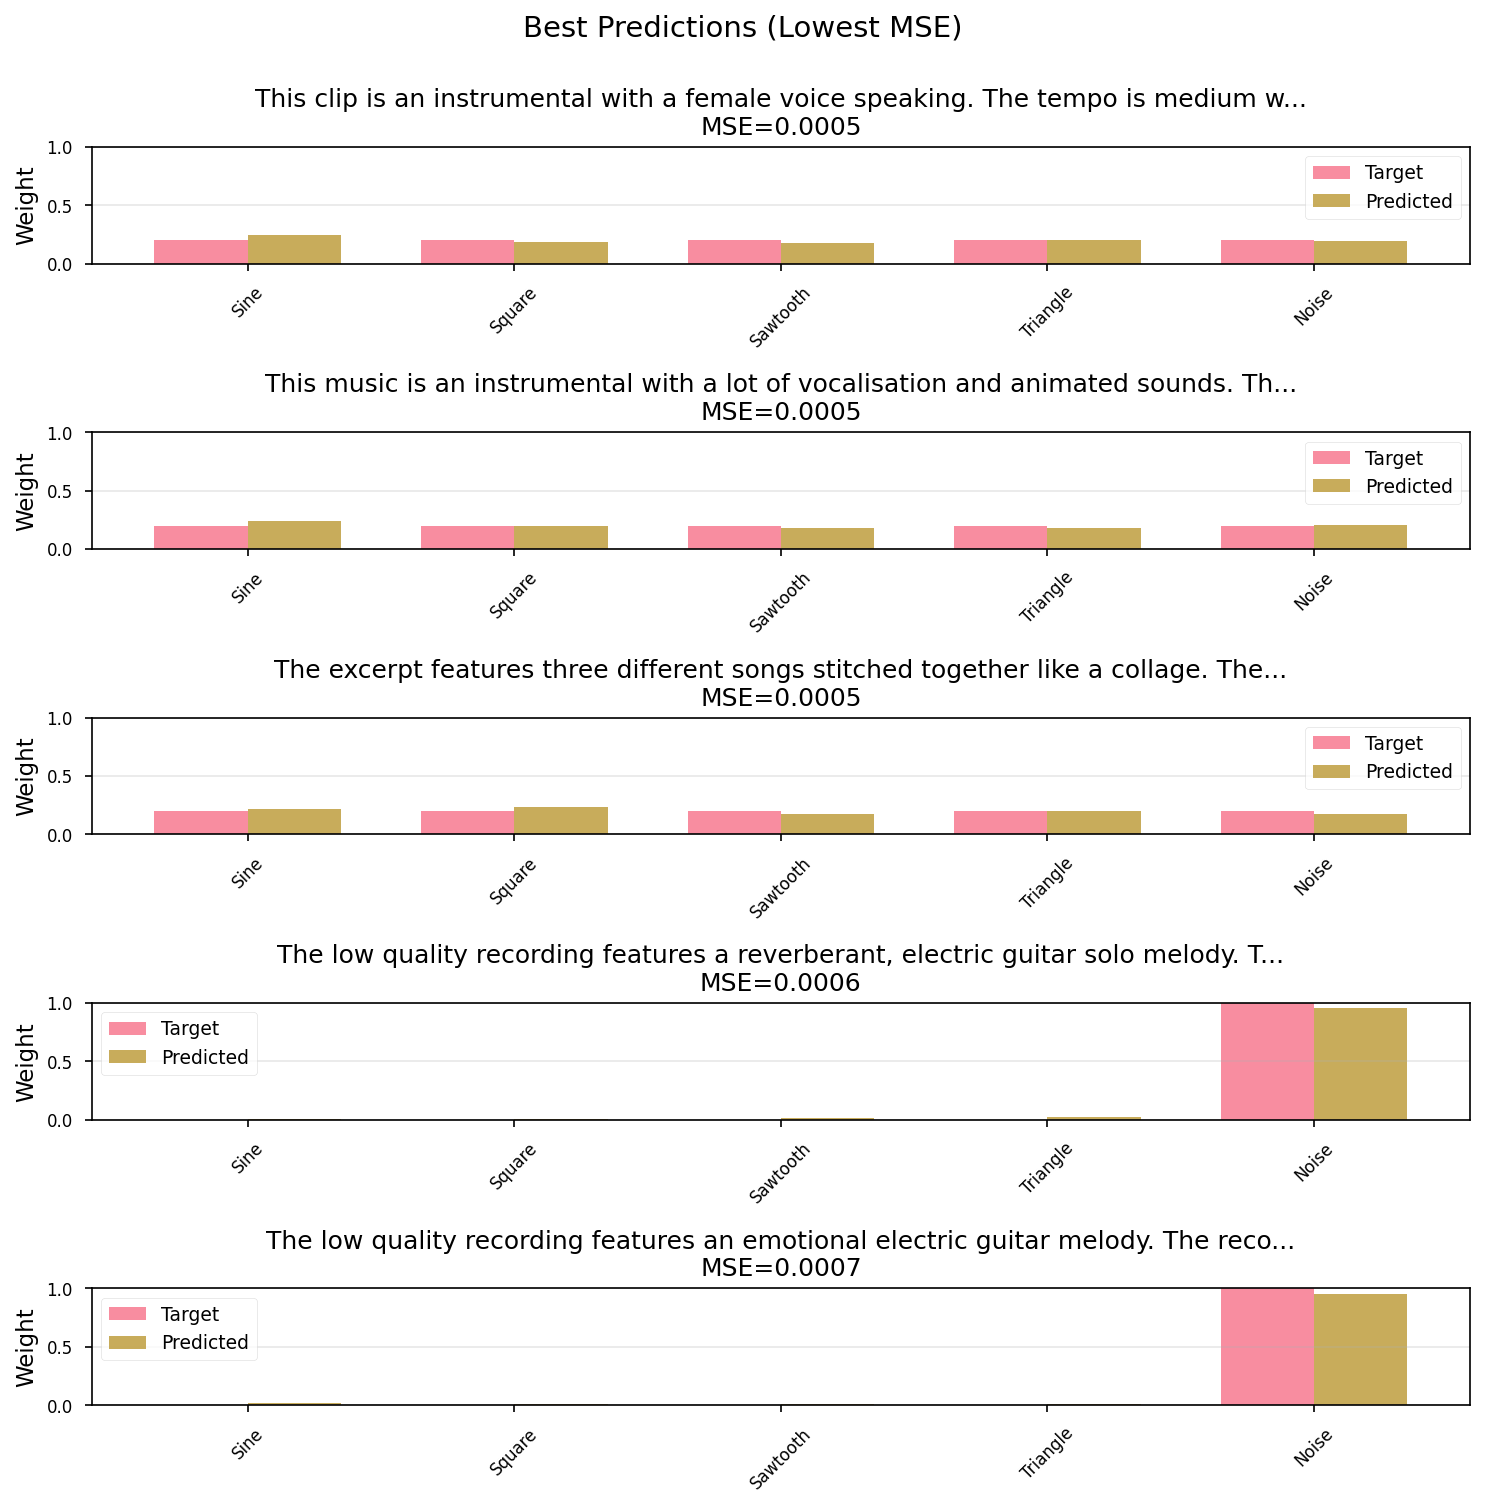

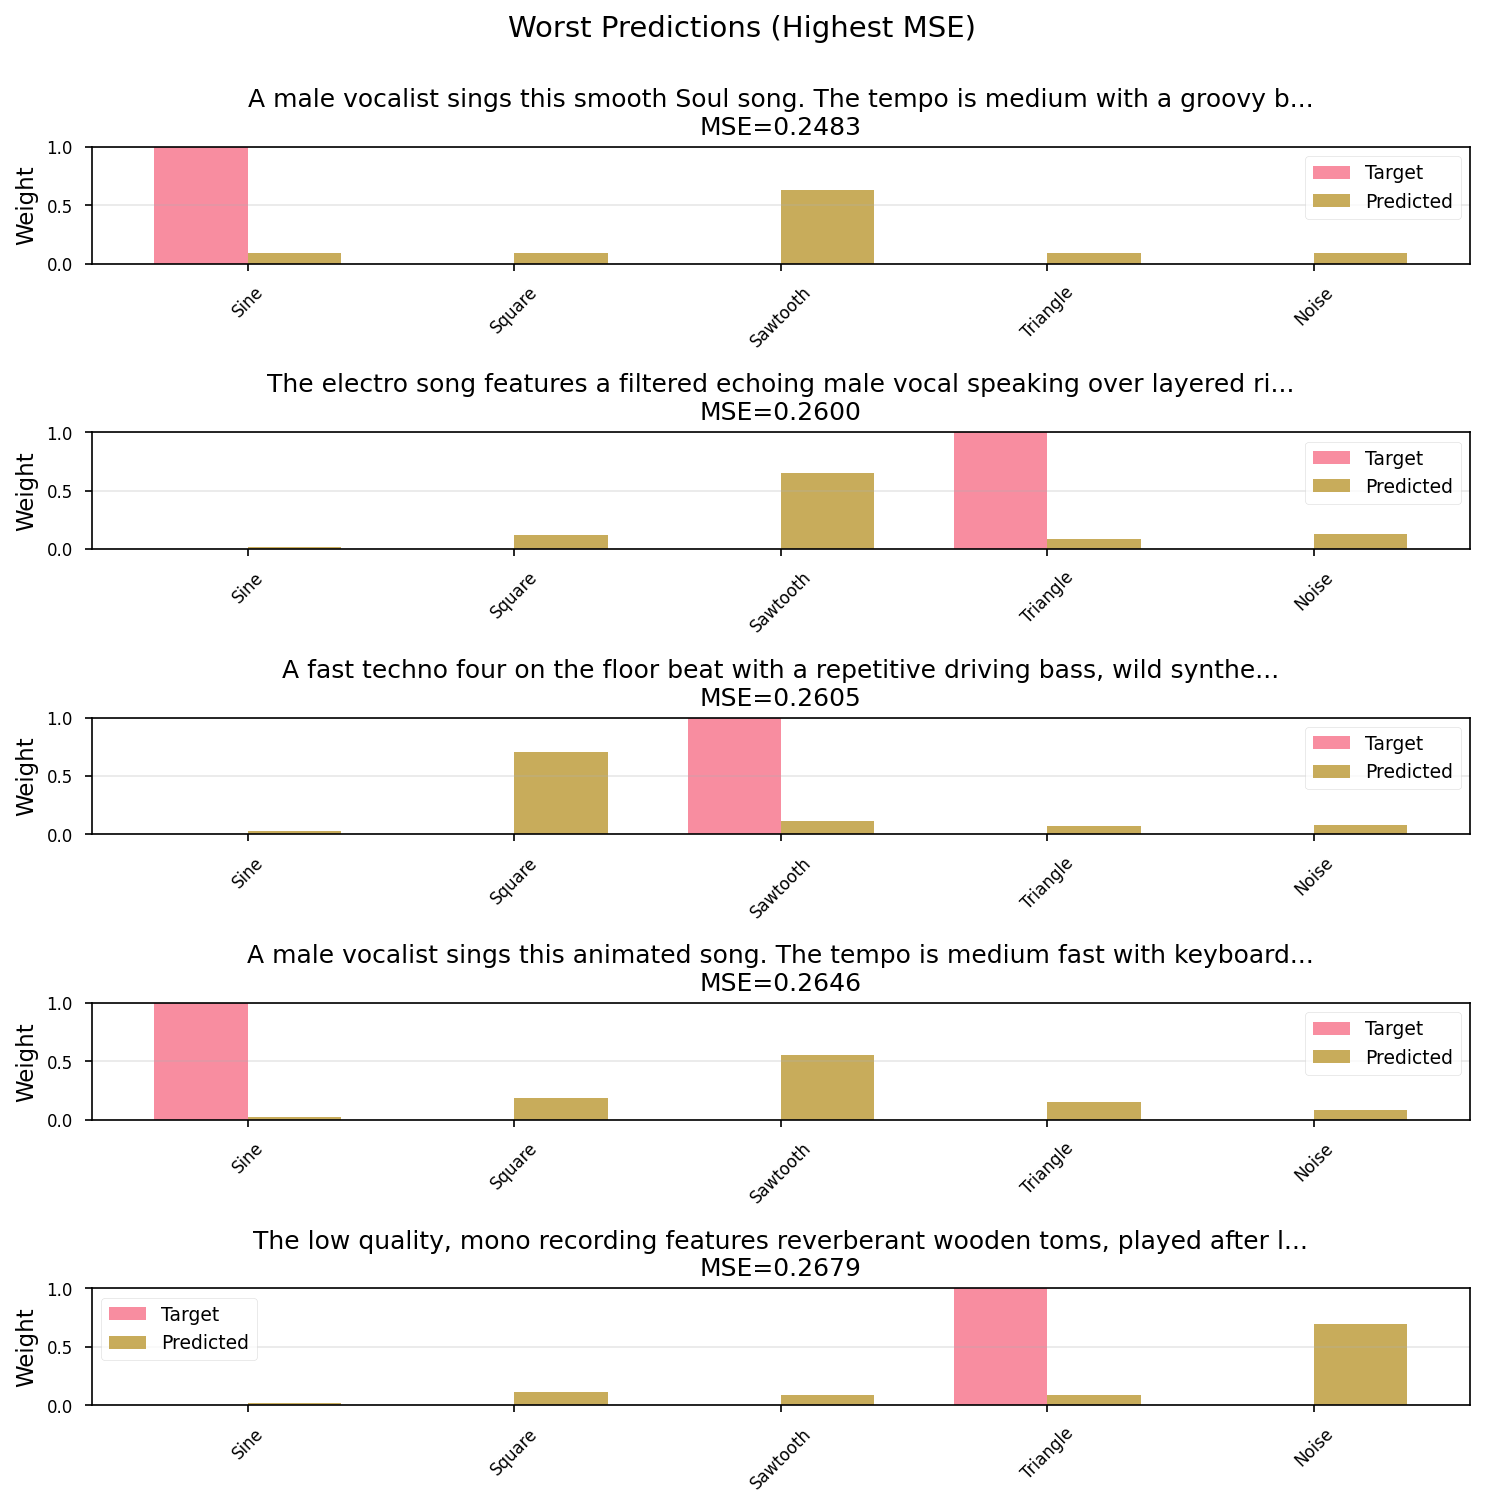

✓ Saved best and worst prediction examples


In [11]:
# Compute per-sample MSE
sample_mses = np.mean((predicted_array - target_array) ** 2, axis=1)

# Find best and worst
best_indices = np.argsort(sample_mses)[:5]
worst_indices = np.argsort(sample_mses)[-5:]

def plot_predictions(indices, title, filename):
    fig, axes = plt.subplots(len(indices), 1, figsize=(10, len(indices)*2))
    if len(indices) == 1:
        axes = [axes]
    
    for i, idx in enumerate(indices):
        ax = axes[i]
        
        pred = predictions[idx]
        x = np.arange(len(archetype_names))
        width = 0.35
        
        ax.bar(x - width/2, pred['target'], width, label='Target', alpha=0.8)
        ax.bar(x + width/2, pred['predicted'], width, label='Predicted', alpha=0.8)
        
        ax.set_ylabel('Weight')
        ax.set_title(f"{pred['description'][:80]}...\nMSE={sample_mses[idx]:.4f}")
        ax.set_xticks(x)
        ax.set_xticklabels([n.capitalize() for n in archetype_names], rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim(0, 1.0)
    
    plt.suptitle(title, fontsize=14, y=1.00)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / filename, dpi=300, bbox_inches='tight')
    plt.show()

plot_predictions(best_indices, 'Best Predictions (Lowest MSE)', 'best_predictions.png')
plot_predictions(worst_indices, 'Worst Predictions (Highest MSE)', 'worst_predictions.png')

print("✓ Saved best and worst prediction examples")

## 9. Summary Statistics Table

In [12]:
# Create summary table
summary_data = []

for i, name in enumerate(archetype_names):
    summary_data.append({
        'Archetype': name.capitalize(),
        'Target Mean': f"{target_array[:, i].mean():.3f}",
        'Predicted Mean': f"{predicted_array[:, i].mean():.3f}",
        'MSE': f"{metrics[f'{name}_mse']:.4f}",
        'Pearson r': f"{pearsonr(predicted_array[:, i], target_array[:, i])[0]:.3f}",
        'Dominant Count (Target)': f"{(target_top1 == i).sum()}",
        'Dominant Count (Predicted)': f"{(pred_top1 == i).sum()}"
    })

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("SUMMARY STATISTICS BY ARCHETYPE")
print("="*80)
print(summary_df.to_string(index=False))

# Save to CSV
summary_df.to_csv(OUTPUT_DIR / 'archetype_summary.csv', index=False)
print(f"\n✓ Saved summary table to {OUTPUT_DIR / 'archetype_summary.csv'}")


SUMMARY STATISTICS BY ARCHETYPE
Archetype Target Mean Predicted Mean    MSE Pearson r Dominant Count (Target) Dominant Count (Predicted)
     Sine       0.355          0.264 0.1131     0.520                     401                        307
   Square       0.161          0.184 0.0523     0.535                     118                        135
 Sawtooth       0.183          0.190 0.0572     0.503                     112                        174
 Triangle       0.146          0.155 0.0545     0.378                      79                         54
    Noise       0.155          0.208 0.0421     0.678                      84                        124

✓ Saved summary table to evaluation_results/archetype_summary.csv


## 10. Generate LaTeX Table for Paper

In [13]:
# Create LaTeX table
latex_table = r"""
\begin{table}[h]
\centering
\caption{Test Set Performance by Archetype}
\label{tab:archetype_performance}
\begin{tabular}{lcccc}
\toprule
Archetype & Target Mean & Predicted Mean & MSE & Pearson $r$ \\
\midrule
"""

for i, name in enumerate(archetype_names):
    pearson_r = pearsonr(predicted_array[:, i], target_array[:, i])[0]
    latex_table += f"{name.capitalize():10s} & {target_array[:, i].mean():.3f} & {predicted_array[:, i].mean():.3f} & {metrics[f'{name}_mse']:.4f} & {pearson_r:.3f} \\\\\n"

latex_table += r"""\midrule
Overall & - & - & """ + f"{metrics['mse']:.4f}" + r" & """ + f"{metrics['pearson_correlation']:.3f}" + r""" \\
\bottomrule
\end{tabular}
\end{table}
"""

# Save LaTeX table
with open(OUTPUT_DIR / 'latex_table.tex', 'w') as f:
    f.write(latex_table)

print("LaTeX Table for Paper:")
print(latex_table)
print(f"\n✓ Saved LaTeX table to {OUTPUT_DIR / 'latex_table.tex'}")

LaTeX Table for Paper:

\begin{table}[h]
\centering
\caption{Test Set Performance by Archetype}
\label{tab:archetype_performance}
\begin{tabular}{lcccc}
\toprule
Archetype & Target Mean & Predicted Mean & MSE & Pearson $r$ \\
\midrule
Sine       & 0.355 & 0.264 & 0.1131 & 0.520 \\
Square     & 0.161 & 0.184 & 0.0523 & 0.535 \\
Sawtooth   & 0.183 & 0.190 & 0.0572 & 0.503 \\
Triangle   & 0.146 & 0.155 & 0.0545 & 0.378 \\
Noise      & 0.155 & 0.208 & 0.0421 & 0.678 \\
\midrule
Overall & - & - & 0.0639 & 0.523 \\
\bottomrule
\end{tabular}
\end{table}


✓ Saved LaTeX table to evaluation_results/latex_table.tex


## 11. Save Complete Results

In [14]:
# Save all predictions for detailed analysis
results_export = {
    'metrics': metrics,
    'predictions': [
        {
            'index': p['index'],
            'description': p['description'],
            'predicted': p['predicted'].tolist(),
            'target': p['target'].tolist(),
            'mse': float(np.mean((p['predicted'] - p['target']) ** 2))
        }
        for p in predictions
    ],
    'archetype_names': archetype_names
}

with open(OUTPUT_DIR / 'complete_results.json', 'w') as f:
    json.dump(results_export, f, indent=2)

print(f"✓ Saved complete results to {OUTPUT_DIR / 'complete_results.json'}")

print("\n" + "="*80)
print("EVALUATION COMPLETE!")
print("="*80)
print(f"\nResults saved to: {OUTPUT_DIR}")
print(f"\nGenerated files:")
for file in sorted(OUTPUT_DIR.glob('*')):
    print(f"  - {file.name}")

✓ Saved complete results to evaluation_results/complete_results.json

EVALUATION COMPLETE!

Results saved to: evaluation_results

Generated files:
  - archetype_distributions.png
  - archetype_summary.csv
  - best_predictions.png
  - classification_report.json
  - complete_results.json
  - confusion_matrix.png
  - error_distribution.png
  - latex_table.tex
  - prediction_vs_target_scatter.png
  - test_metrics.json
  - worst_predictions.png
